# Import Libraries

In [1]:
import numpy as np
import tensorflow as tf
import random as rn
import os
from tensorflow import keras
from keras.models import Model
from keras.layers import Dense, Input, Flatten, Activation, Dropout, Layer,InputLayer
from keras.utils import to_categorical
from keras import optimizers,initializers,constraints,regularizers
from keras import backend as K
from keras.callbacks import LambdaCallback,ModelCheckpoint
from keras.utils import plot_model

import pandas as pd
import matplotlib.pyplot as plt
import math
from sklearn.decomposition import PCA

import warnings

warnings.filterwarnings("ignore")
seed=0
os.environ['PYTHONHASHSEED'] = str(seed)

np.random.seed(seed)
rn.seed(seed)

tf.random.set_seed(450)

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'



2023-08-30 17:36:05.892751: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-30 17:36:06.116271: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-08-30 17:36:06.116412: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-08-30 17:36:07.249908: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

# Reading data

In [2]:
#Access data
data_path='../data/data_mouse.csv'

data = pd.read_csv(data_path)

train_data = np.array(data)[:,1:]
n_samples = train_data.shape[0]
n_genes = train_data.shape[1]
print (train_data.shape)

(48, 45101)


# Normalize data

In [3]:
#Normalization
mean = np.sum(train_data)/(n_samples*n_genes)
normalized_data=(train_data-mean)/np.sqrt(np.mean((train_data-mean)*(train_data-mean)))

# PCA on normalized data and find eigen genes

In [4]:
n_eigen_genes = 4
train_data_T = normalized_data.transpose()
pca = PCA(n_components = n_eigen_genes)
pca.fit(train_data_T)

pca_normalized = pca.components_.transpose()


In [5]:
# hidden layers
hidd_1 = 8
hidd_2 = 4
hidd_3 = 2

# hyperparameters
lr = 0.5
training_epochs = 1000
batch_size = 12
lambda_fac = 1e-1

# initialization of learnable parameters
L_init = 0.05
alpha_init = 0.05
A_init = 0.25
period_init = 4.5


# Train data

In [6]:
#Model
class PENN(Model):
    def __init__(self,dynamic=True):
        super().__init__()      

        #learnable variables
        self.L = tf.Variable(
                        lambda: L_init+tf.zeros(shape=(1,n_eigen_genes)),
                        trainable= True) #leverage
        self.alpha = tf.Variable(
                        lambda: alpha_init+tf.zeros(shape=(1,n_eigen_genes)),
                        trainable= True) #phase shift
        self.A = tf.Variable(
                        lambda: A_init+tf.zeros(shape=(1,n_eigen_genes)),
                        trainable= True) #amplitude
        self.period = tf.Variable(
                        lambda: period_init+tf.zeros(shape=(1,n_eigen_genes)),
                        trainable= True) #period
        
        #layers
        self.input_ = InputLayer(input_shape=(n_eigen_genes,))
        self.enc0= Dense(hidd_1,activation='linear',
                            kernel_initializer="glorot_uniform",
                            bias_initializer="zeros")
        self.enc1 = Dense(hidd_2,activation='linear',
                            kernel_initializer="glorot_uniform",
                            bias_initializer="zeros")
        self.enc2 = Dense(hidd_3,activation='linear',
                            kernel_initializer="glorot_uniform",
                            bias_initializer="zeros")
        self.enc3 = Dense(hidd_3,activation=self.fit_cos,
                            kernel_initializer="glorot_uniform",
                            bias_initializer="zeros",dynamic=True)
        self.dec0 = Dense(hidd_2,activation='linear',
                            kernel_initializer="glorot_uniform",
                            bias_initializer="zeros")
        self.dec1 = Dense(hidd_1,activation='linear',
                            kernel_initializer="glorot_uniform",
                            bias_initializer="zeros")
        self.dec2 = Dense(n_eigen_genes,activation='softmax',
                            kernel_initializer="glorot_uniform",
                            bias_initializer="zeros")
        
        #initialization of the function for fitting part of the loss
        self.Y = tf.zeros((batch_size,n_eigen_genes))
        

    def fit_cos(self, x):
        
        #bottleneck outputs
        x_0_=x[:,0]
        x_1_=x[:,1]
        
        #requirement to be on a unit circle
        for_sin=x_0_/K.sqrt(K.square(x_0_)+K.square(x_1_))
        for_cos=x_1_/K.sqrt(K.square(x_0_)+K.square(x_1_))
        
        pi_on_180 = 0.017453292519943295
        
        #finding phase using arc tan
        a = tf.atan2(for_sin, for_cos) * 180. / np.pi
        t = tf.where(a <= 0, 360 + a, a) * pi_on_180
        
        # broadcasting the parameters for vectorize calc
        L_broadcasted = tf.expand_dims(self.L, axis=0)
        A_broadcasted = tf.expand_dims(self.A, axis=0)
        alpha_broadcasted = tf.expand_dims(self.alpha, axis=0)
        period_broadcasted = tf.expand_dims(self.period, axis=0)
        
        #cos function "Y" which used to fit each genes to based on different Leverage, Amplitude, Period and Phase shift
        Y = L_broadcasted + A_broadcasted * tf.cos(period_broadcasted*t[:, tf.newaxis] + alpha_broadcasted)

        self.const = Y
        
        return K.stack([for_sin,for_cos],axis=1)
     
    def encoding(self, x):
        
        inp = self.input_(x)
        x = self.enc0(inp)
        x = self.enc1(x)
        x = self.enc2(x)
        x = self.enc3(x)
        return x
        
    def enc_out(self):
        
        x = keras.layers.Input(shape=(n_eigen_genes,))
        return tf.keras.Model(inputs=x, outputs=self.encoding(x))
    

    def call(self, x):

        inp = self.input_(x)
        x = self.encoding(inp)
        
        #cosine fitting loss
        self.add_loss(lambda_fac*tf.keras.backend.mean(
                      (tf.keras.backend.mean
                          ((inp-self.const)**2,axis=1))))
    
        x = self.dec0(x)
        x = self.dec1(x)
        x = self.dec2(x)
    
        return x

    
autoencoder = PENN(dynamic=True)

encoder = autoencoder.enc_out()

optimizer = optimizers.SGD(learning_rate=lr)
autoencoder.compile(optimizer=optimizer,loss='mse',run_eagerly=True)

# train data
train_dat = pca_normalized

# training
autoencoder.fit(train_dat, train_dat, epochs=training_epochs, batch_size=batch_size, shuffle=True)

autoencoder.summary()

2023-08-30 17:36:36.863278: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-08-30 17:36:36.863460: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-08-30 17:36:36.863556: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (xinxingwu4): /proc/driver/nvidia/version does not exist
2023-08-30 17:36:36.864657: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/1000
4/4 [==============================] - 0s 51ms/step - loss: 0.0685
Epoch 2/1000
4/4 [==============================] - 0s 51ms/step - loss: 0.0645
Epoch 3/1000
4/4 [==============================] - 0s 50ms/step - loss: 0.0618
Epoch 4/1000
4/4 [==============================] - 0s 50ms/step - loss: 0.0663
Epoch 5/1000
4/4 [==============================] - 0s 50ms/step - loss: 0.0624
Epoch 6/1000
4/4 [==============================] - 0s 51ms/step - loss: 0.0618
Epoch 7/1000
4/4 [==============================] - 0s 51ms/step - loss: 0.0616
Epoch 8/1000
4/4 [==============================] - 0s 50ms/step - loss: 0.0614
Epoch 9/1000
4/4 [==============================] - 0s 51ms/step - loss: 0.0609
Epoch 10/1000
4/4 [==============================] - 0s 50ms/step - loss: 0.0605
Epoch 11/1000
4/4 [==============================] - 0s 50ms/step - loss: 0.0611
Epoch 12/1000
4/4 [==============================] - 0s 51ms/step - loss: 0.0602
Epoch 13/1000
4/4 [==================

# Predict phases

In [7]:
encoded_data= encoder.predict(train_dat,batch_size=batch_size)
for_sin=encoded_data[:,0]
for_cos=encoded_data[:,1]
        
a = tf.atan2(for_sin, for_cos) * 180. / np.pi
phases = tf.where(a <= 0, 360 + a, a) 
print (phases)


4/4 [==============================] - 0s 11ms/step
tf.Tensor(
[ 60.567192   68.71708    69.35869    86.6133     98.80821   113.73902
 108.1114     92.00585   125.22156   153.64989   137.00893   130.15053
 164.6179    192.53513   201.31302   218.70503   234.10696   276.57788
 271.98166   279.4109    319.99585   350.637       1.1490954  10.012484
  44.216602   66.4621     57.521755   87.40604    91.35099   114.04367
  98.59843   108.933464  113.32894   112.3575    128.92593   175.5041
 160.44226   159.55452   219.84361   228.303     249.90201   227.97624
 267.53543   310.3069    325.62042   336.83557   344.5451    358.87207  ], shape=(48,), dtype=float32)


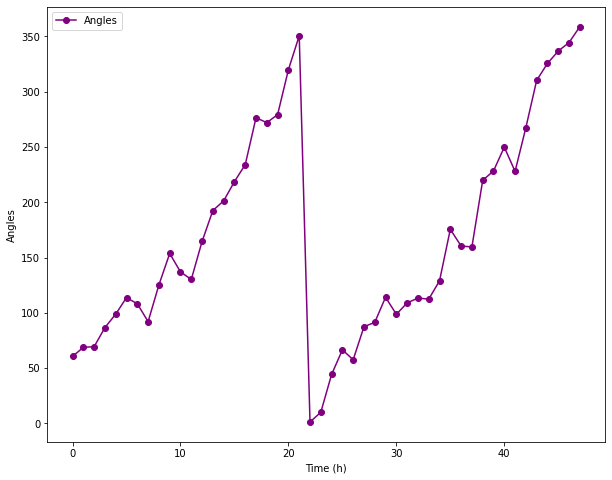

In [8]:
plt.figure(figsize=(10,8))
plt.plot(phases,marker= 'o',color='purple',label='Angles')

plt.ylabel('pred angles')
plt.xlabel('indices')

plt.legend()
plt.show()NR1D2

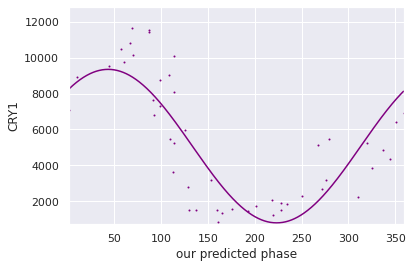

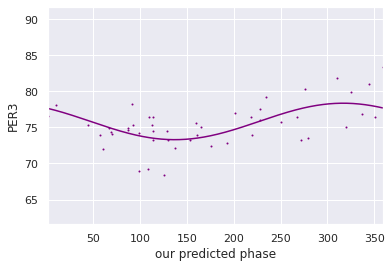

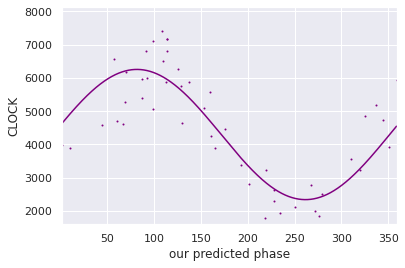

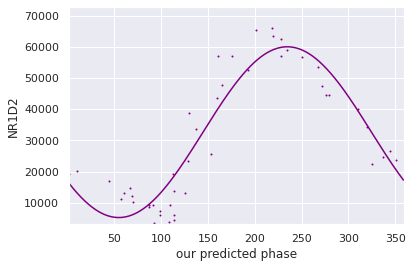

4 genes checked


In [14]:
from CosinorPy import file_parser, cosinor, cosinor1

times = np.array(phases)

CRY1= (train_data[:,18038])
PER3 = (train_data[:,5391])
CLOCK = (train_data[:,2989])
NR1D2 = (train_data[:,1288])

cosinor.fit_me(times,CRY1,n_components=1,period=360,plot_margins=False,color='purple',y_label='CRY1', x_label='our predicted phase',plot_phase=False)
cosinor.fit_me(times,PER3,n_components=1,period=360,plot_margins=False,color='purple',y_label='PER3', x_label='our predicted phase',plot_phase=False)
cosinor.fit_me(times,CLOCK,n_components=1,period=360,plot_margins=False,color='purple',y_label='CLOCK', x_label='our predicted phase',plot_phase=False)
cosinor.fit_me(times,NR1D2,n_components=1,period=360,plot_margins=False,color='purple',y_label='NR1D2', x_label='our predicted phase',plot_phase=False)
print ("4 genes checked")



In [10]:
x_hours_=np.arange(0, 24, 1)
x_hours = np.tile(x_hours_,2)
phases_for_plot = (np.array(phases)*24./360.)

In [11]:
# We tuned CYCLOPS heavily and obtained the following results

CYCLOPS =[81.11910067493393, 89.48578209180548, 90.32594558898603, 106.77334702347795, 118.12864053912605, 133.56134685723532, 129.7505763124506, 114.16550895473378, 146.64016684596263, 174.39933304805567, 160.41245089475785, 150.80398864764152, 180.53522304174584, 210.35792985323468, 218.2705532683406, 234.76691608855123, 248.32477384866235, 301.2344859301972, 297.0435297692826, 302.08395740765764, 349.70025210994237, 18.623715671652363, 28.400496229929246, 38.08916091605604, 67.49275695991979, 87.45295480617104, 80.68752425357859, 107.1380638271896, 116.77438969609462, 135.45016375226996, 121.36094939917915, 130.7885167626802, 135.17939340899187, 134.90377609334814, 149.7672105428909, 192.44699971864233, 178.41835193274449, 179.6422725522684, 234.25018447099467, 243.50145423812822, 265.8854885077559, 243.23619032896835, 285.2044945083327, 328.3564002535121, 346.89017679371756, 358.7500818906344, 7.063136752373094, 22.83266640688314]
CYCLOPS = np.array(CYCLOPS)*24./360.

In [17]:
import seaborn as sns
sns.set()
def tolplot(label, prediction_1,prediction_2, add=True):
    
    err = np.abs(prediction_1 - label)
    err = np.minimum(err, 24 - err)
    offset = np.linspace(0, 12)
    acc_with_hour = np.array([100 * np.sum(np.abs(err) > off) / len(err) for off in offset])
    err2 = np.abs(prediction_2 - label)
    err2 = np.minimum(err2, 24 - err2)
    acc_with_hour_2  = np.array([100 * np.sum(np.abs(err2) > off) / len(err2) for off in offset])
    
    
    plt.figure(figsize=(7,7))

    if add:
        plt.plot(offset, 100 - acc_with_hour, color='blue', label= "PENN",)
        plt.plot(offset, 100 - acc_with_hour_2, color='red', label = "CYCLOPS",linestyle='-')
        plt.xlim(0, 12)
        plt.xlabel("Correct to within (hrs)",fontsize=22)
        plt.ylabel("% Correct",fontsize=22)
        plt.xticks(np.arange(0, 13, step=1))
        plt.yticks(np.arange(0, 101, step=10))

    else:
        plt.plot(offset, 100 - acc_with_hour, color='blue')
    
    acc_normal = (100 - acc_with_hour) / 100
    acc_normal_2 = (100 - acc_with_hour_2) / 100
    offset_normal = offset / 12
    auc = np.sum(acc_normal[1:] * np.diff(offset_normal))
    auc1 = np.sum(acc_normal_2[1:] * np.diff(offset_normal))
    plt.text(7, 20, f"AUC PENN={auc:.2f}", fontsize=12, fontweight='bold')
    plt.text(7, 25, f"AUC CYCLOPS={auc1:.2f}", fontsize=12, fontweight='bold')
       
    plt.legend()
    plt.savefig("AUC_mice.eps")
    plt.show()
    
    return auc

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


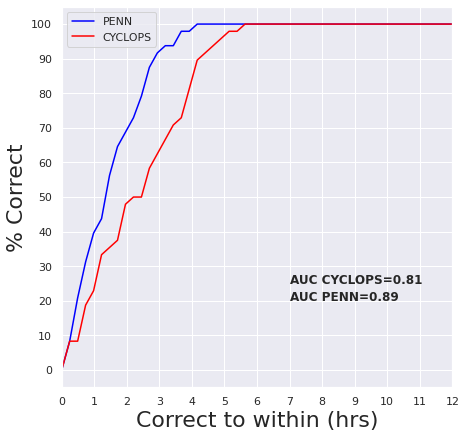

0.8873299319727891

In [18]:
tolplot(x_hours, phases_for_plot, CYCLOPS, add=True)
